In [1]:
#@title Code Library
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pdb
import random
from tqdm import tqdm, tqdm_notebook
def df_handle_outliers(dataset):
  for col in dataset.columns:
    if col!='TimeStamp':
      Q1 = dataset[col].quantile(0.25)
      Q3 = dataset[col].quantile(0.75)
      IQR = Q3 - Q1
      whisker_width = 1.5
      lower_whisker = Q1 -(whisker_width*IQR)
      upper_whisker = Q3 + (whisker_width*IQR)
      dataset[col]=np.where(dataset[col]>upper_whisker,upper_whisker,np.where(dataset[col]<lower_whisker,lower_whisker,dataset[col]))
  return dataset
def add_dataRow(dataset, dataRow, columns):
  temp_df = pd.DataFrame([dataRow], columns= columns)
  dataset = dataset.append(temp_df, ignore_index= True)
  return dataset

def data_overview(dataset, target_variable):
  df = dataset.drop(columns = target_variable)

  columns = ["Observation", "Value"]
  result_dataset = pd.DataFrame(columns=columns)

  result_dataset = add_dataRow(result_dataset, ["Number of rows", df.shape[0]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of columns", df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of numeric variables", df._get_numeric_data().shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of categorical variables", df.select_dtypes(include="category").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of text & id variables", df.select_dtypes(include=object).shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of logical variables", df.select_dtypes(include="bool").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of date variables", df.select_dtypes(include="datetime64").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of uniform variables", df.loc[:,df.apply(pd.Series.nunique) == 1].shape[1]], columns)

  null_df = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=["null_sum"])
  result_dataset = add_dataRow(result_dataset, ["% of complete case rows",(null_df[null_df["null_sum"] == 0].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (<50%)",(null_df[null_df["null_sum"] <= 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>50%)",(null_df[null_df["null_sum"] > 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>90%)",(null_df[null_df["null_sum"] > 0.9].shape[0]*100)/df.shape[1]], columns)



  return result_dataset

def target_variable_info(dataset, target_variable):
  classes = np.unique(dataset[target_variable])
  
  columns=["Observation","Value"]
  df = pd.DataFrame(columns= columns)

  df = add_dataRow(df, ["Number of classes", len(classes)], columns)
  for xclass in classes:
    value = dataset[dataset[target_variable] == xclass].shape[0]
    df = add_dataRow(df, ["Number of data points in class " + str(xclass), value], columns)

  return df

def df_without_outliers(dataset, col, count=False):
  # pdb.set_trace()
  firstQuantile = dataset[col].quantile(0.25)
  thirdQuantile = dataset[col].quantile(0.75)
  IQR = thirdQuantile - firstQuantile
  leftFence = firstQuantile - (1.5*IQR)
  rightFence = thirdQuantile + (1.5*IQR)
  if count:
    dataset = dataset[(dataset[col] < leftFence) | (dataset[col] > rightFence)]
  else:
    dataset = dataset[(dataset[col] >= leftFence) & (dataset[col] <= rightFence)]

  return dataset

def numerical_overview(dataset, target_variable):
  df = dataset.drop(columns= target_variable)._get_numeric_data()

  columns = ["Variable name", "+ve value count", "-ve value count", "Zero count", \
             "Unique count", "+ve infinity count", "-ve infinity count", \
             "missing %", "Count of outliers"]

  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[df[col] > 0].shape[0])
    dataRow.append(df[df[col] < 0].shape[0])
    dataRow.append(df[df[col] == 0].shape[0])
    dataRow.append(len(df[col].unique()))
    dataRow.append(df[df[col] == np.inf].shape[0])
    dataRow.append(df[df[col] == -np.inf].shape[0])
    dataRow.append((df[col].isnull().sum()*100)/df.shape[0])
    dataRow.append(df_without_outliers(df, col, True).shape[0])

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def categorical_feature_overview(dataset, target_variable):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable).select_dtypes(include="category")

  columns = ["Variable name", "Unique categories", "% missing values"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(len(pd.unique(df[col])))
    dataRow.append(round(((df[col].isnull().sum())*100)/df.shape[0], 3))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def min_text_count(df, col):
  min = -1
  for val in df[col]:
    if not pd.isna(val):
      newMin = len(val.split(" "))
      if min == -1 or min > len(val.split(" ")):
        min = newMin
  
  return min

def max_text_count(df, col):
  max = -1
  for val in df[col]:
    if not pd.isna(val):
      newMax = len(val.split(" "))
      if max == -1 or max < len(val.split(" ")):
        max = newMax
  
  return max

def text_feature_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable).select_dtypes(include=object)

  columns = ["Variable name", "No. of unique words", "Min no. of words in a document", "Max no. of words in a document", "% missing data"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []
    if "id" not in col.lower():
      df[col] = df[col].apply(lambda x : re.sub('\W+',' ', str(x).lower()) if not pd.isna(x) else x)
      # print(df[col])
      dataRow.append(col)
      dataRow.append(len(pd.unique(df[col])))
      dataRow.append(min_text_count(df, col))
      dataRow.append(max_text_count(df, col))
      # print((df[col].isnull()))
      dataRow.append(round((df[col].isnull().sum()*100)/df.shape[0], 2))

      result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def stat_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable)._get_numeric_data()

  columns = ["Variable name", "Count", "Mean", "Standard deviation", "Variance", \
             "Min", "25th Percentile", "50th Percentile", "75th Percentile", \
             "Max", "10th Percentile", "90th Percentile", "95th Percentile"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[col].count())
    dataRow.append(df[col].mean())
    dataRow.append(df[col].std())
    dataRow.append(df[col].var())
    dataRow.append(df[col].min())
    dataRow.append(df[col].quantile(0.25))
    dataRow.append(df[col].quantile(0.50))
    dataRow.append(df[col].quantile(0.75))
    dataRow.append(df[col].max())
    dataRow.append(df[col].quantile(0.10))
    dataRow.append(df[col].quantile(0.90))
    dataRow.append(df[col].quantile(0.95))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def density_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  fig, axes = plt.subplots(df.shape[1],figsize=(5,df.shape[1]*5))
  for index, col in enumerate(df.columns):
    if "id" not in col:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.distplot(plot_df[col], ax=a)

def box_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  figs, axes = plt.subplots(df.shape[1], figsize = (5, df.shape[1]*5))

  for index, col in enumerate(df.columns):
    if "id" not in col and col != target_variable:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.boxplot(y=plot_df[col], ax=a,orient="v")

def stacked_bar_plot(dataset ,target_variable, top=10):
  # pdb.set_trace()
  data = dataset.select_dtypes(include="category")
  for x_variable in data.columns:

    df = pd.DataFrame(dataset.groupby(x_variable)[target_variable].agg(lambda x : x.eq(1).sum())).reset_index()
    print(df.columns)
    df["total"] = dataset.groupby(x_variable)[target_variable].agg(total="count").reset_index()["total"]
    df.sort_values(by=['total'],inplace=True, ascending=False)

    if df.shape[0] > top:
      df = df[:top]

    ind = np.arange(df.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, df["total"].values)
    p2 = plt.bar(ind, df[target_variable].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(df[x_variable].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [22]:
df = pd.read_excel("..\Datasets\Result_Price.xlsx")

In [23]:
df.head(2)

,Model,RMSE,MSE,MAE,R2
0,Sarimax,59.801332,3576.199303,48.856201,0.136742
1,Prophet,53.590683,2871.961253,41.557972,0.306738


<AxesSubplot: title={'center': 'Evaluation Metrics for Electricity Price'}, xlabel='Error Metric', ylabel='Models Evaluated'>

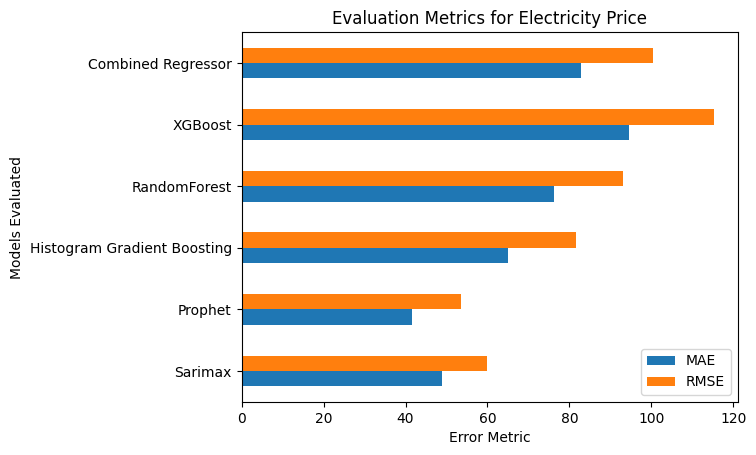

In [26]:
df.plot(x='Model',y=['MAE','RMSE'],
        kind='barh',
        stacked=False,
        title='Evaluation Metrics for Electricity Price',xlabel='Error Metric',ylabel='Models Evaluated')



In [27]:
newdf = pd.read_excel("..\Datasets\Result_Demand.xlsx")

<AxesSubplot: title={'center': 'Evaluation Metrics for Energy Demand'}, xlabel='Error Metric', ylabel='Models Evaluated'>

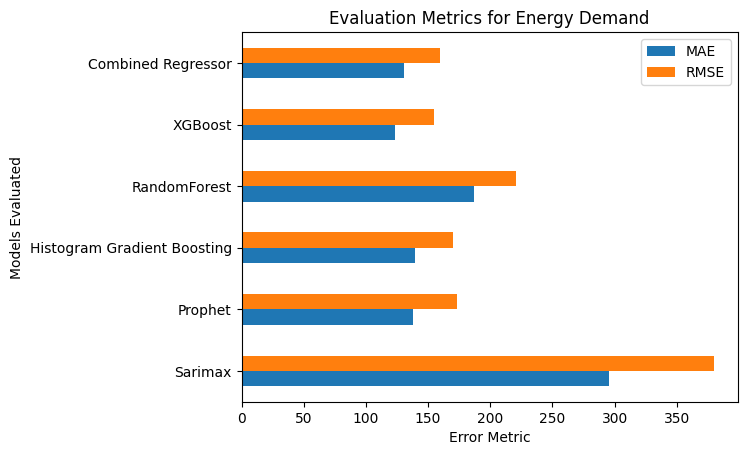

In [28]:
newdf.plot(x='Model',y=['MAE','RMSE'],
        kind='barh',
        stacked=False,
        title='Evaluation Metrics for Energy Demand',xlabel='Error Metric',ylabel='Models Evaluated')

In [2]:
newdf = pd.read_csv("..\Datasets\PriceResultEnsemble.csv")

In [3]:
newdf.tail(2)

,TimeStamp,hgb,xgb,rfr,vr,actual,prophet,sarimax
143,2022-01-06 23:00:00,91.145030,184.839024,163.8113,140.893758,154.240000,205.430828,160.698181
144,2022-01-07 00:00:00,95.916745,156.725297,171.2364,149.902448,156.096225,203.188846,NaN


In [4]:
newdf['TimeStamp'] = pd.to_datetime(newdf['TimeStamp'], format='%Y-%m-%dT%H:%M:%S')
newdf = newdf.set_index('TimeStamp')
newdf = newdf.asfreq('H')
newdf = newdf.sort_index()

In [5]:
y_true = newdf['actual']

In [6]:
newdf=newdf.drop(columns='actual')

In [7]:
newdf['avgprice'] = newdf.mean(axis=1)
newdf.head(2)

,hgb,xgb,rfr,vr,prophet,sarimax,avgprice
TimeStamp,,,,,,,
2022-01-01 00:00:00,3.642053,11.973358,30.4353,18.238809,178.768848,132.106899,62.527544
2022-01-01 01:00:00,-7.474700,5.758698,16.9639,11.585469,177.609117,128.523850,55.494389


In [8]:
newypred = newdf['avgprice']

In [9]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error, r2_score,explained_variance_score


In [37]:
print('RMSE:',mean_squared_error(y_true, newypred, squared = False))
print('MSE:',mean_squared_error(y_true, newypred))
print('MAE:',mean_absolute_error(y_true, newypred))
print('MAPE:',mean_absolute_percentage_error(y_true, newypred))
print('Max Error:',max_error(y_true, newypred))
print('Explained Variance Score:',explained_variance_score(y_true, newypred))
print('R2Score:',r2_score(y_true, newypred))

RMSE: 71.09989931672867
MSE: 5055.195682848953
MAE: 61.113129446952144
MAPE: 2759385812030330.0
Max Error: 132.16387589918259
Explained Variance Score: 0.3766755888547938
R2Score: 0.04945391231944729


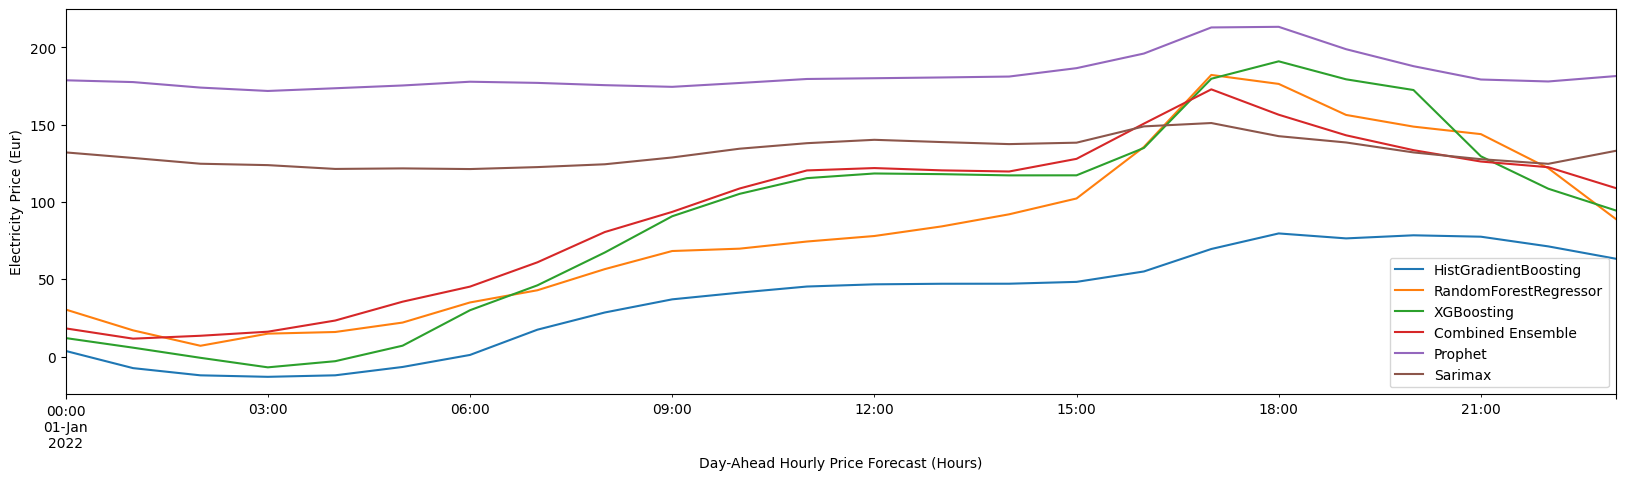

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
#y_true.head(24).plot(ax=ax, label='Actual')
newdf['hgb'].head(24).plot(ax=ax, label='HistGradientBoosting')
newdf['rfr'].head(24).plot(ax=ax, label='RandomForestRegressor')
newdf['xgb'].head(24).plot(ax=ax, label='XGBoosting')
newdf['vr'].head(24).plot(ax=ax, label='Combined Ensemble')
newdf['prophet'].head(24).plot(ax=ax, label='Prophet')
newdf['sarimax'].head(24).plot(ax=ax, label='Sarimax')
#newypred.head(24).plot(ax=ax, label='combined')
ax.legend();
plt.xlabel('Day-Ahead Hourly Price Forecast (Hours)')
plt.ylabel('Electricity Price (Eur)')
#plt.title('Number of Carriers Flying from Specific Airports')
plt.show()

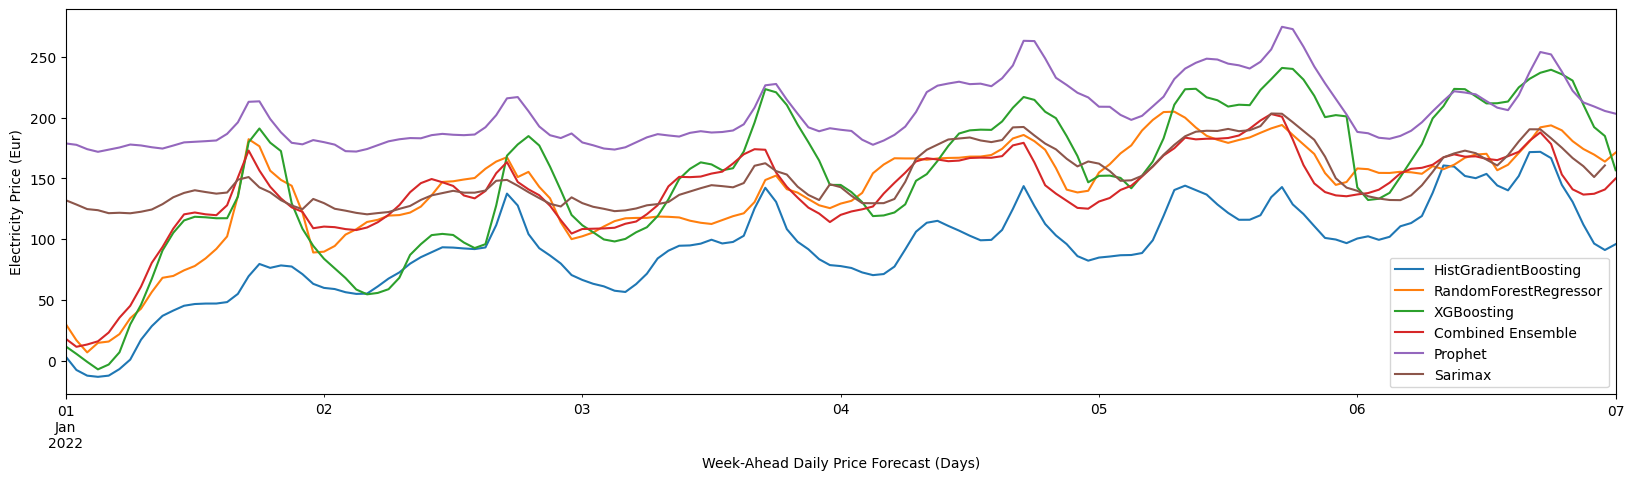

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))
newdf['hgb'].plot(ax=ax, label='HistGradientBoosting')
newdf['rfr'].plot(ax=ax, label='RandomForestRegressor')
newdf['xgb'].plot(ax=ax, label='XGBoosting')
newdf['vr'].plot(ax=ax, label='Combined Ensemble')
newdf['prophet'].plot(ax=ax, label='Prophet')
newdf['sarimax'].plot(ax=ax, label='Sarimax')
#newypred.plot(ax=ax, label='combined')
#y_true.plot(ax=ax, label='Actual')
plt.xlabel('Week-Ahead Daily Price Forecast (Days)')
plt.ylabel('Electricity Price (Eur)')
ax.legend();
plt.show()